In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [4]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

The kilonovae discovery metric is similar to some other population-based metrics (such as the microlensing and TDE detection metrics). The key elements are a metric -- which defines the detection or characterization criteria for each event -- and a custom slicer -- which defines the locations and lightcurves for the events. 

The slicer is a UserPointsSlicer, with additional information tied to each slicePoint. A UserSlicePoint lets the user define RA/Dec values for the slicePoints over the sky (the locations of each event). This is then augmented by additional information on *when* the events happens and what the lightcurve looks like (or any other information about each event), tied to each slicePoint. Each slicePoint then represents each event. The slicer is set up by a function related to the metric called something like `generateKNPopSlicer` (or `generateMicrolensingSlicer`) -- this function read information about the lightcurves and where they should be distributed, sets up the UserPointSlicer with that RA/Dec information, and then adds lightcurve information as appropriate.

The metric then gets the information about the observations at each slicePoint (each RA/Dec value) as well as the slicePoint information related to the lightcurve (such as the time of the peak or the shape of the event, etc) -- the brightness at the time of each observation is generally up to the metric to calculate or interpolate as it will depend on the timing of the observations from the simulation. The metric evaluates the observed points on the lightcurve against its criteria for discovery or characterization, etc. and returns an appropriate value. For some metrics this will be a simple 0/1 (discovered or not) but for other metrics it might be something like how accurately the lightcurve could be fit. 



## Set up and run the KNe metric. ## 

In [5]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)

In [22]:
n_events = 30000

# Kilonova parameters - set up to run on a particular subset of the KNe models
# Just one GW170817 - like model:
inj_params_list = [{'mej_dyn': 0.005,
                    'mej_wind': 0.050,
                    'phi': 30,
                    'theta': 25.8},
                   ]
filename = maf.get_KNe_filename(inj_params_list)
slicer_single = maf.generateKNPopSlicer(n_events=n_events, n_files=len(filename), d_min=10, d_max=600)
metric_single = maf.KNePopMetric(outputLc=False, file_list=filename, metricName='KNePopMetric_single')

Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 25.8}
Found matches for 1/1           sets of parameters


In [23]:
n_events = 30000

# Kilonova parameters - set up to run on a particular subset of the KNe models
# All models
filename = maf.get_KNe_filename(None)
slicer_all = maf.generateKNPopSlicer(n_events=n_events, n_files=len(filename), d_min=10, d_max=600)
metric_all = maf.KNePopMetric(outputLc=False, file_list=filename, metricName='KNePopMetric_all')

In [24]:
# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.SumMetric(metricName='Total detected'), 
                  maf.CountMetric(metricName='Total lightcurves in footprint'),
                  maf.CountMetric(metricName='Total lightcurves on sky', maskVal=0),
                  maf.MeanMetric(metricName='Fraction detected in footprint'), 
                  maf.MeanMetric(maskVal=0, metricName='Fraction detected of total')]

In [25]:
bundle_single = maf.MetricBundle(metric_single, slicer_single, None, 
                                 info_label='single model',runName=opsim, summaryMetrics=summaryMetrics)
bundle_all = maf.MetricBundle(metric_all, slicer_all, None, 
                              info_label='all models', runName=opsim, summaryMetrics=summaryMetrics)

In [26]:
outDir = 'test_kne'
bdict = {'single': bundle_single, 'all': bundle_all}
g = maf.MetricBundleGroup(bdict, opsdb, outDir)

In [27]:
g.runAll()

Querying table None with no constraint for columns ['filter', 'fieldDec', 'rotSkyPos', 'night', 'fiveSigmaDepth', 'fieldRA', 'observationStartMJD'].
Found 2081749 visits
Running:  ['single']
Completed metric generation.
Running:  ['all']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [28]:
bdict.keys()

dict_keys(['single', 'all', 'KNePopMetric_single__blue_color_detect', 'KNePopMetric_single__multi_color_detect', 'KNePopMetric_single__multi_detect', 'KNePopMetric_single__red_color_detect', 'KNePopMetric_single__ztfrest_simple', 'KNePopMetric_single__ztfrest_simple_blue', 'KNePopMetric_single__ztfrest_simple_red', 'KNePopMetric_all__blue_color_detect', 'KNePopMetric_all__multi_color_detect', 'KNePopMetric_all__multi_detect', 'KNePopMetric_all__red_color_detect', 'KNePopMetric_all__ztfrest_simple', 'KNePopMetric_all__ztfrest_simple_blue', 'KNePopMetric_all__ztfrest_simple_red'])

## Look at the metric outputs. ##

The KNeMetric returns 0/1 whether the metric could be detected or not. 

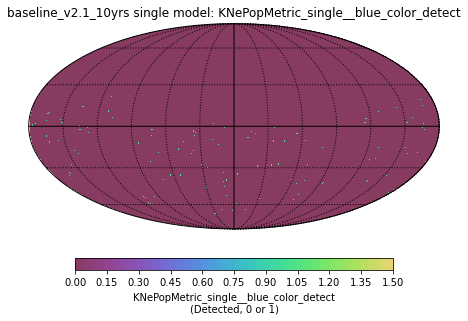

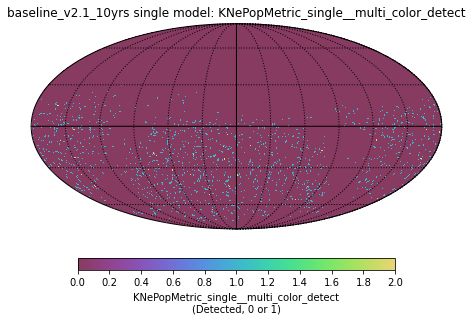

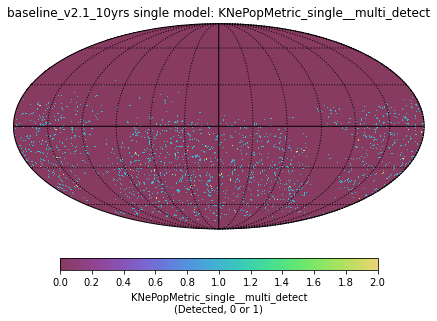

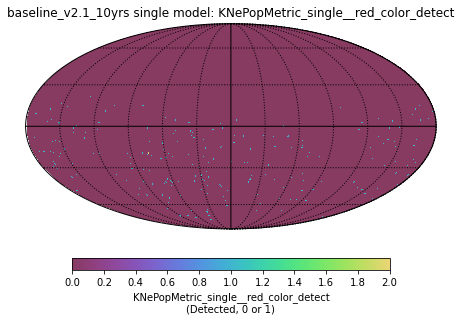

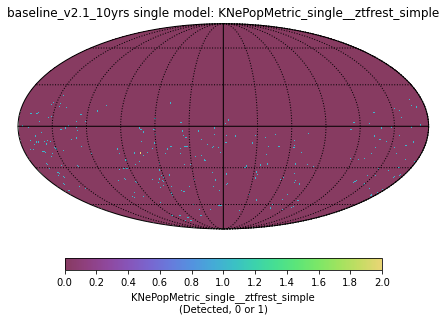

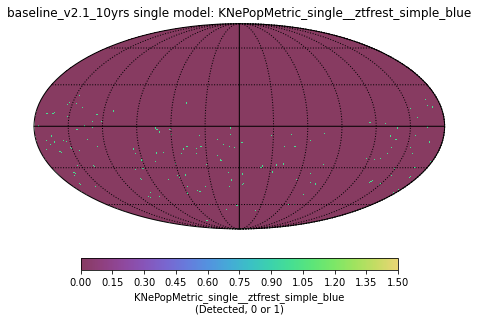

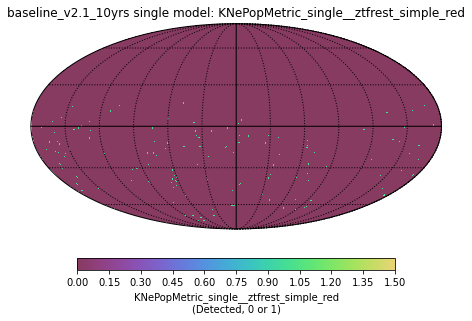

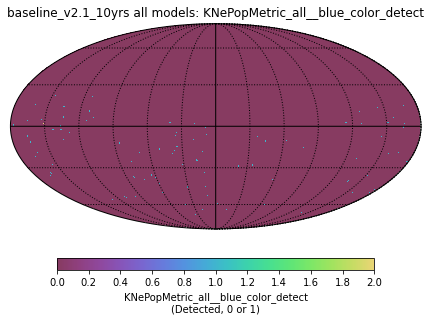

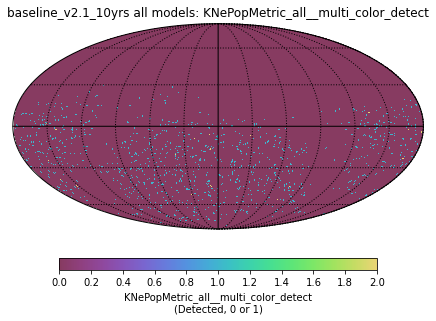

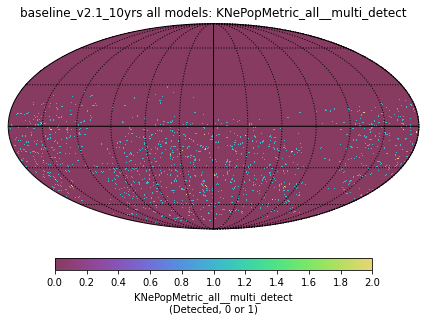

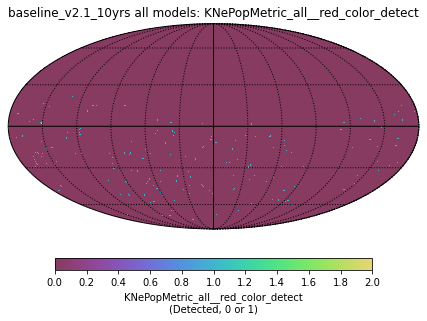

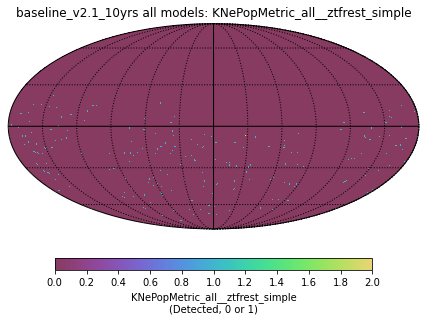

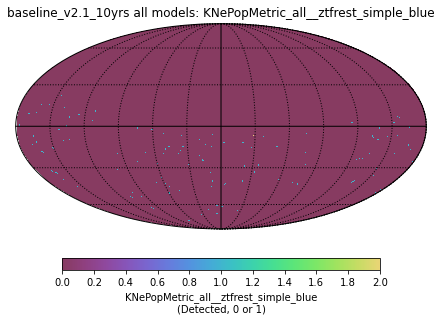

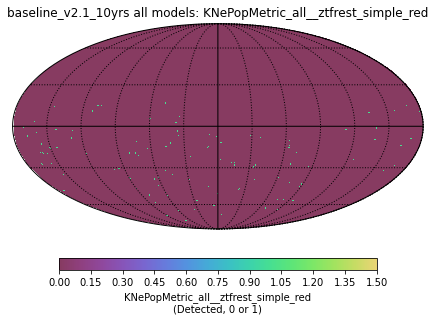

In [29]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('KN'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

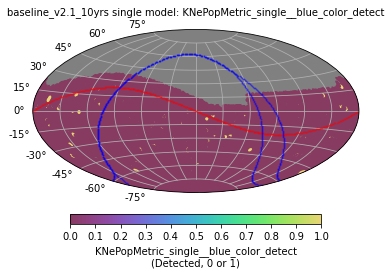

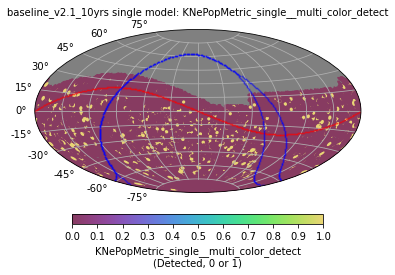

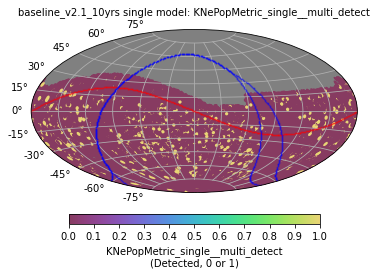

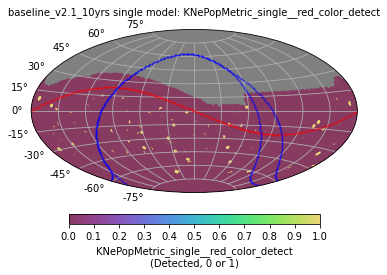

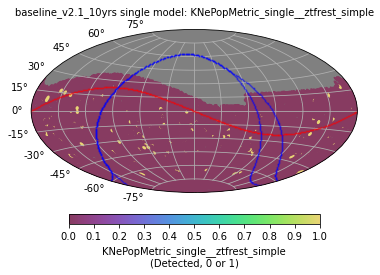

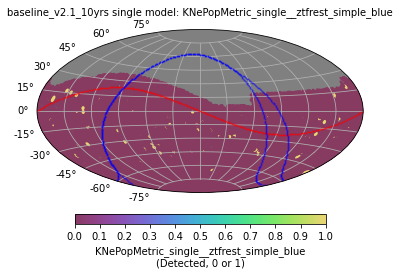

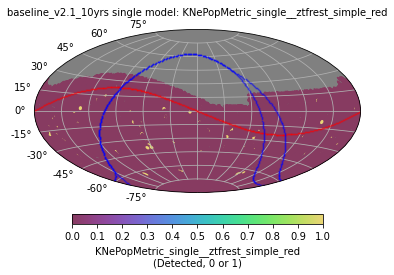

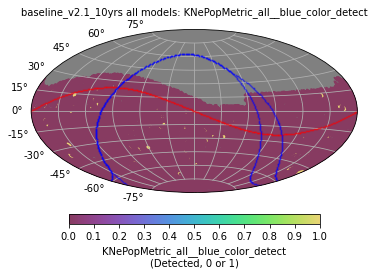

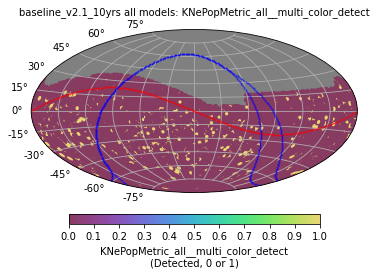

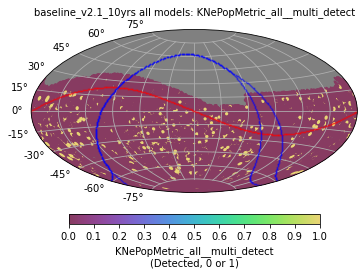

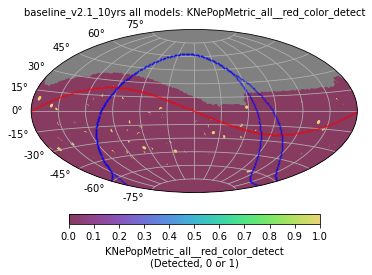

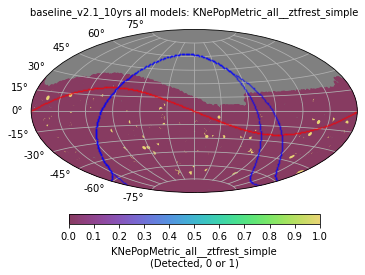

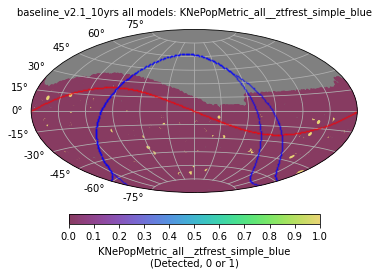

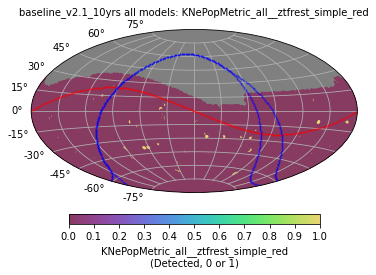

In [30]:
# If you do want to show each individual point - this is slower
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('KN'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc)

In [31]:
pd.DataFrame([bdict[k].summaryValues for k in bdict.keys() if k.startswith('KN')], 
             index=[k.replace('_', ' ') for k in bdict if k.startswith('KN')])

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint,Fraction detected of total
KNePopMetric single blue color detect,111.0,20489,30000,0.005418,0.003700
KNePopMetric single multi color detect,1395.0,20489,30000,0.068085,0.046500
KNePopMetric single multi detect,1575.0,20489,30000,0.076871,0.052500
KNePopMetric single red color detect,221.0,20489,30000,0.010786,0.007367
KNePopMetric single ztfrest simple,254.0,20489,30000,0.012397,0.008467
KNePopMetric single ztfrest simple blue,149.0,20489,30000,0.007272,0.004967
KNePopMetric single ztfrest simple red,134.0,20489,30000,0.006540,0.004467
KNePopMetric all blue color detect,92.0,20489,30000,0.004490,0.003067
KNePopMetric all multi color detect,1094.0,20489,30000,0.053395,0.036467
KNePopMetric all multi detect,1234.0,20489,30000,0.060227,0.041133


In [34]:
# Illustrate some things about the metric values: (caught in summary metrics)
m = 'KNePopMetric_all__multi_detect'
print(f'How many lightcurves were added? (over the entire sky) {len(bdict[m].metricValues)}')
print(f'How many lightcurves were added in areas that were part of the survey footprint?' ,
      f'{len(bdict[m].metricValues.compressed())}')
print(f'What are the metric values for each of these light curves? '
      f'{np.unique(bdict[m].metricValues.compressed())}')
print(f'How many lightcurves were *successfully* detected? {bdict[m].metricValues.sum()}')
print(len(np.where(bdict[m].metricValues == 1)[0]))
frac_total = bdict[m].metricValues.sum() / len(bdict[m].metricValues)
print(f'Fraction of total lightcurves detected {frac_total}')
frac_footprint = bdict[m].metricValues.sum() / len(bdict[m].metricValues.compressed())
print(f'Fraction of lightcurves within footprint detected {frac_footprint}')

How many lightcurves were added? (over the entire sky) 30000
How many lightcurves were added in areas that were part of the survey footprint? 20489
What are the metric values for each of these light curves? [0. 1.]
How many lightcurves were *successfully* detected? 1234.0
1234
Fraction of total lightcurves detected 0.041133333333333334
Fraction of lightcurves within footprint detected 0.06022743911367075


## Look at the slicer information (how the lightcurves were added). ##

The slicer holds the slicePoint information, including the information about where the events occured and what the lightcurves looked like before adding observational information (i.e. in the model).

In [35]:
# The *slicer* keeps the information about the injected lightcurves too
print(f'How many lightcurves added over the sky? {len(bdict[m].slicer)}')

How many lightcurves added over the sky? 30000


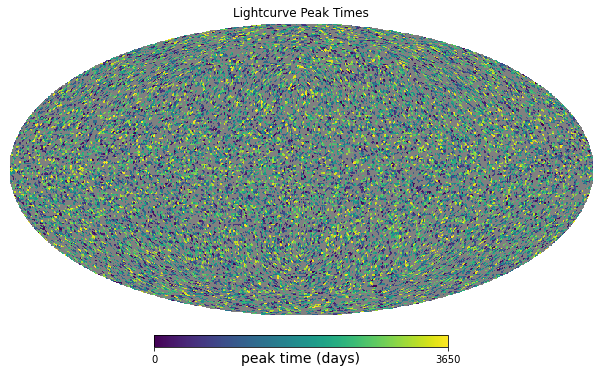

In [38]:
# Including their spatial, time and distance distribution
hp.mollview(rsUtils._healbin(slicer_all.slicePoints['ra'], slicer_all.slicePoints['dec'], 
                             slicer_all.slicePoints['peak_time'], 64, reduceFunc=np.mean), 
            unit='peak time (days)', title='Lightcurve Peak Times', min=0, max=3650)

Text(0.5, 1.0, 'Distance distribution KNe')

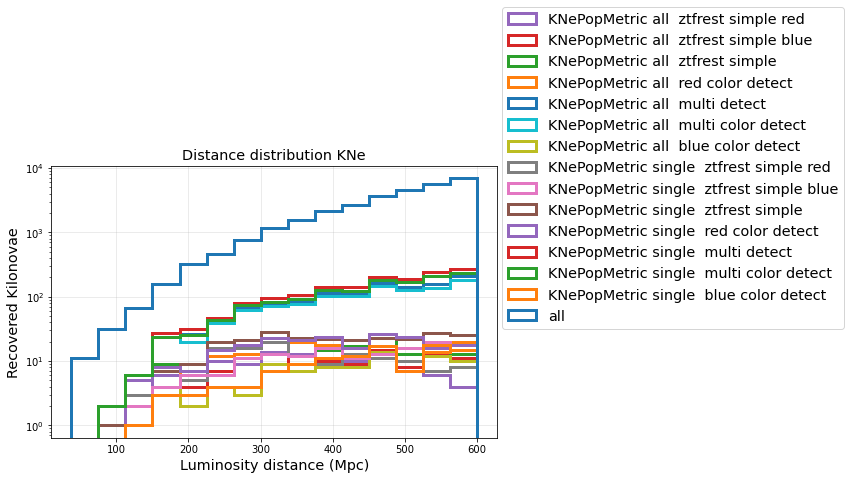

In [39]:
# And the distance distribution -- which we can also modify to show detected objects
distances = {}
distances['all'] = slicer_all.slicePoints['distance']
for k in bdict:
    if k.startswith('KN'):
        detected = np.where(bdict[k].metricValues == 1)
        distances[k] = distances['all'][detected]

plt.figure(figsize=(8, 5))
n,b,p = plt.hist([distances[k] for k in distances], 
                 label=[k.replace('_', ' ').replace('KNePopMetric  ', '') for k in distances], 
                 bins=15, histtype='step', linewidth=3, density=False, cumulative=False)
plt.xlabel("Luminosity distance (Mpc)", fontsize='x-large')
plt.ylabel("Recovered Kilonovae", fontsize='x-large')
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc=(1.01, 0.4), fontsize='x-large', fancybox=True)
plt.title('Distance distribution KNe', fontsize='x-large')

Text(0.5, 1.0, 'Distance distribution KNe')

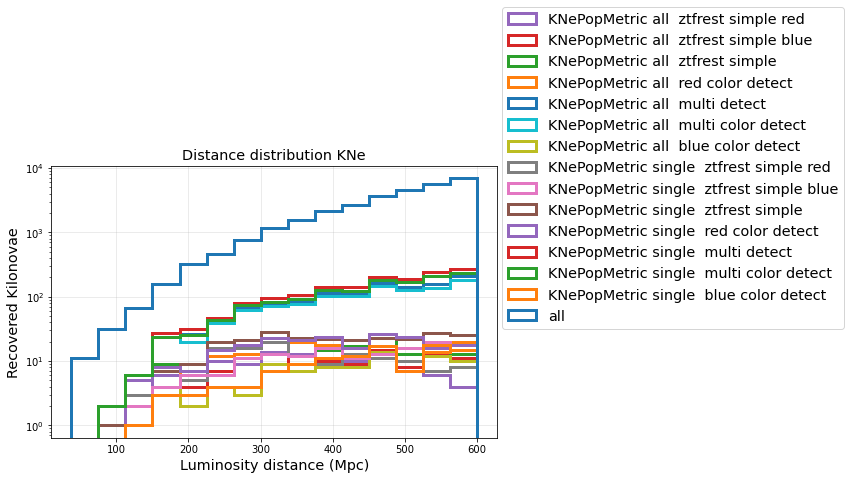

In [40]:
# And the distance distribution -- which we can also modify to show detected objects
distances = {}
distances['all'] = slicer_single.slicePoints['distance']
for k in bdict:
    if k.startswith('KN'):
        detected = np.where(bdict[k].metricValues == 1)
        distances[k] = distances['all'][detected]

plt.figure(figsize=(8, 5))
n,b,p = plt.hist([distances[k] for k in distances], 
                 label=[k.replace('_', ' ').replace('KNePopMetric  ', '') for k in distances], 
                 bins=15, histtype='step', linewidth=3, density=False, cumulative=False)
plt.xlabel("Luminosity distance (Mpc)", fontsize='x-large')
plt.ylabel("Recovered Kilonovae", fontsize='x-large')
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc=(1.01, 0.4), fontsize='x-large', fancybox=True)
plt.title('Distance distribution KNe', fontsize='x-large')

Mean 0.04147813097126779 Min 0.0 Max 0.16161616161616163 RMS 0.030270697657407294


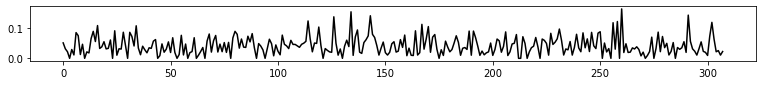

In [42]:
# The 'file_indx' in the slicePoint tracks which lightcurve (which file) was used for each point.
# So, with different input files we can check to see if there is a different fraction of objects detected.
indxes = np.unique(slicer_all.slicePoints['file_indx'])
detfraction = np.zeros(len(indxes))
for i, indx in enumerate(indxes):
    in_indx = np.where(slicer_all.slicePoints['file_indx'] == indx)[0]
    n_total = in_indx.size
    # This simply requires two detections, regardless of band
    detfraction[i] = bdict['KNePopMetric_all__multi_detect'].metricValues[in_indx].sum()/n_total

plt.figure(figsize=(13, 1))
plt.plot(indxes, detfraction, 'k-')
print(f'Mean {np.mean(detfraction)} Min {np.min(detfraction)} Max {np.max(detfraction)} RMS {np.std(detfraction)}')

(0.0, -20.0)

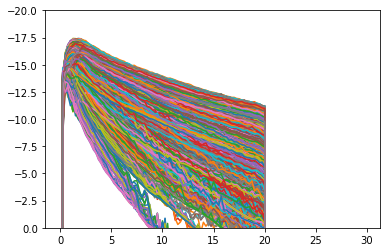

In [51]:
# what do the lightcurves look like?
lcs = maf.KN_lc(filename)
times = np.arange(0, 30, 0.25)

for i in range(len(filename)):
    for f in 'ugrizy':
        mags = lcs.interp(times, f, lc_indx=i)
        plt.plot(times, mags)

        plt.ylim(0, -20)

### Look at the metric outputs across the v2 runs ###


In [55]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = '/Users/lynnej/lsst_repos/survey_strategy/fbs_2.0/summary_2022_06_22.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metric_sets = maf.get_metric_sets()

In [67]:
# Make a comparison of the KNePopMetric with single and all models
two_obs_detect = [m for m in summaries if 'KNePopMetric' in m and 'Total detected' in m and 'multi_detect' in m]
color_rise_detect = [m for m in summaries if 'KNePopMetric' in m 
                     and 'Total detected' in m and 'ztfrest_simple' in m and 'blue' not in m and 'red' not in m]
metrics = two_obs_detect + color_rise_detect
styles = ['r-', 'b-'] + ['r:', 'b:']
msub = maf.create_metric_set_df('kne_comparison', metrics, 
                                short_name=[m.replace('UserPointsSlicer', '').rstrip(' ') for m in metrics],
                               style=styles)
msub

metric  \
metric set     metric                                                                                                  
kne_comparison Total detected KNePopMetric_single__multi_detec...  Total detected KNePopMetric_single__multi_dete...   
               Total detected KNePopMetric_all__multi_detect a...  Total detected KNePopMetric_all__multi_detect ...   
               Total detected KNePopMetric_single__ztfrest_sim...  Total detected KNePopMetric_single__ztfrest_si...   
               Total detected KNePopMetric_all__ztfrest_simple...  Total detected KNePopMetric_all__ztfrest_simpl...   

                                                                                                          short_name  \
metric set     metric                                                                                                  
kne_comparison Total detected KNePopMetric_single__multi_detec...  Total detected KNePopMetric_single__multi_dete...   
               Total detected KNePopMetric_all__multi_detect a...  Total detected KNePopMetric_all__multi_detect ...   
               Total detected KNePopMetric_single__ztfrest_sim...  Total detected KNePopMetric_single__ztfrest_si...   
               Total detected KNePopMetric_all__ztfrest_simple...  Total detected KNePopMetric_all__ztfrest_simpl...   

                                                                  style  \
metric set     metric                                                     
kne_comparison Total detected KNePopMetric_single__multi_detec...    r-   
               Total detected KNePopMetric_all__multi_detect a...    b-   
               Total detected KNePopMetric_single__ztfrest_sim...    r:   
               Total detected KNePopMetric_all__ztfrest_simple...    b:   

                                                                   invert  \
metric set     metric                                                       
kne_comparison Total detected KNePopMetric_single__multi_detec...   False   
               Total detected KNePopMetric_all__multi_detect a...   False   
               Total detected KNePopMetric_single__ztfrest_sim...   False   
               Total detected KNePopMetric_all__ztfrest_simple...   False   

                                                                     mag  
metric set     metric                                                     
kne_comparison Total detected KNePopMetric_single__multi_detec...  False  
               Total detected KNePopMetric_all__multi_detect a...  False  
               Total detected KNePopMetric_single__ztfrest_sim...  False  
               Total detected KNePopMetric_all__ztfrest_simple...  False

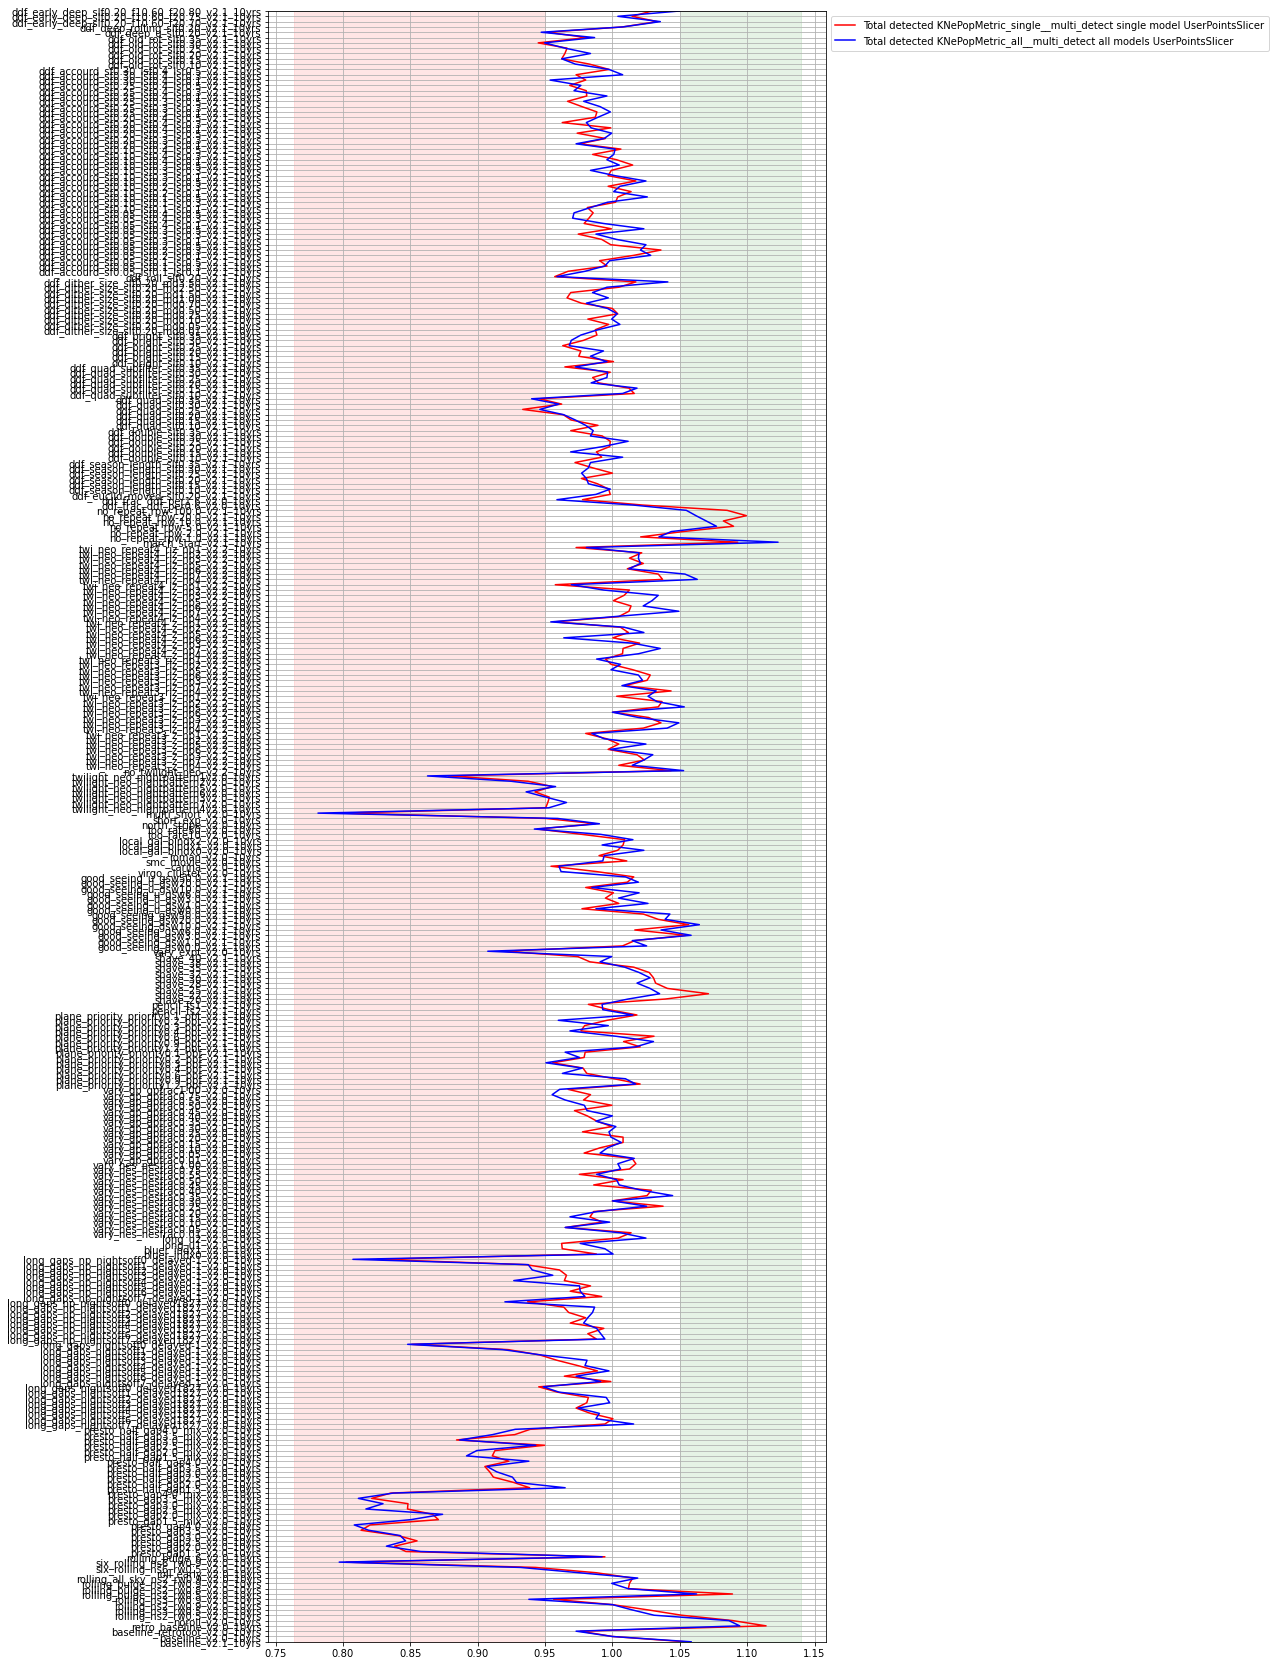

In [74]:
these_runs = families.explode('run')['run']
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, two_obs_detect],
                             baseline_run='baseline_v2.0_10yrs',
                              metric_set=msub,
                             horizontal_quantity='value',
                             vertical_quantity='run')
fig.set_figheight(30)

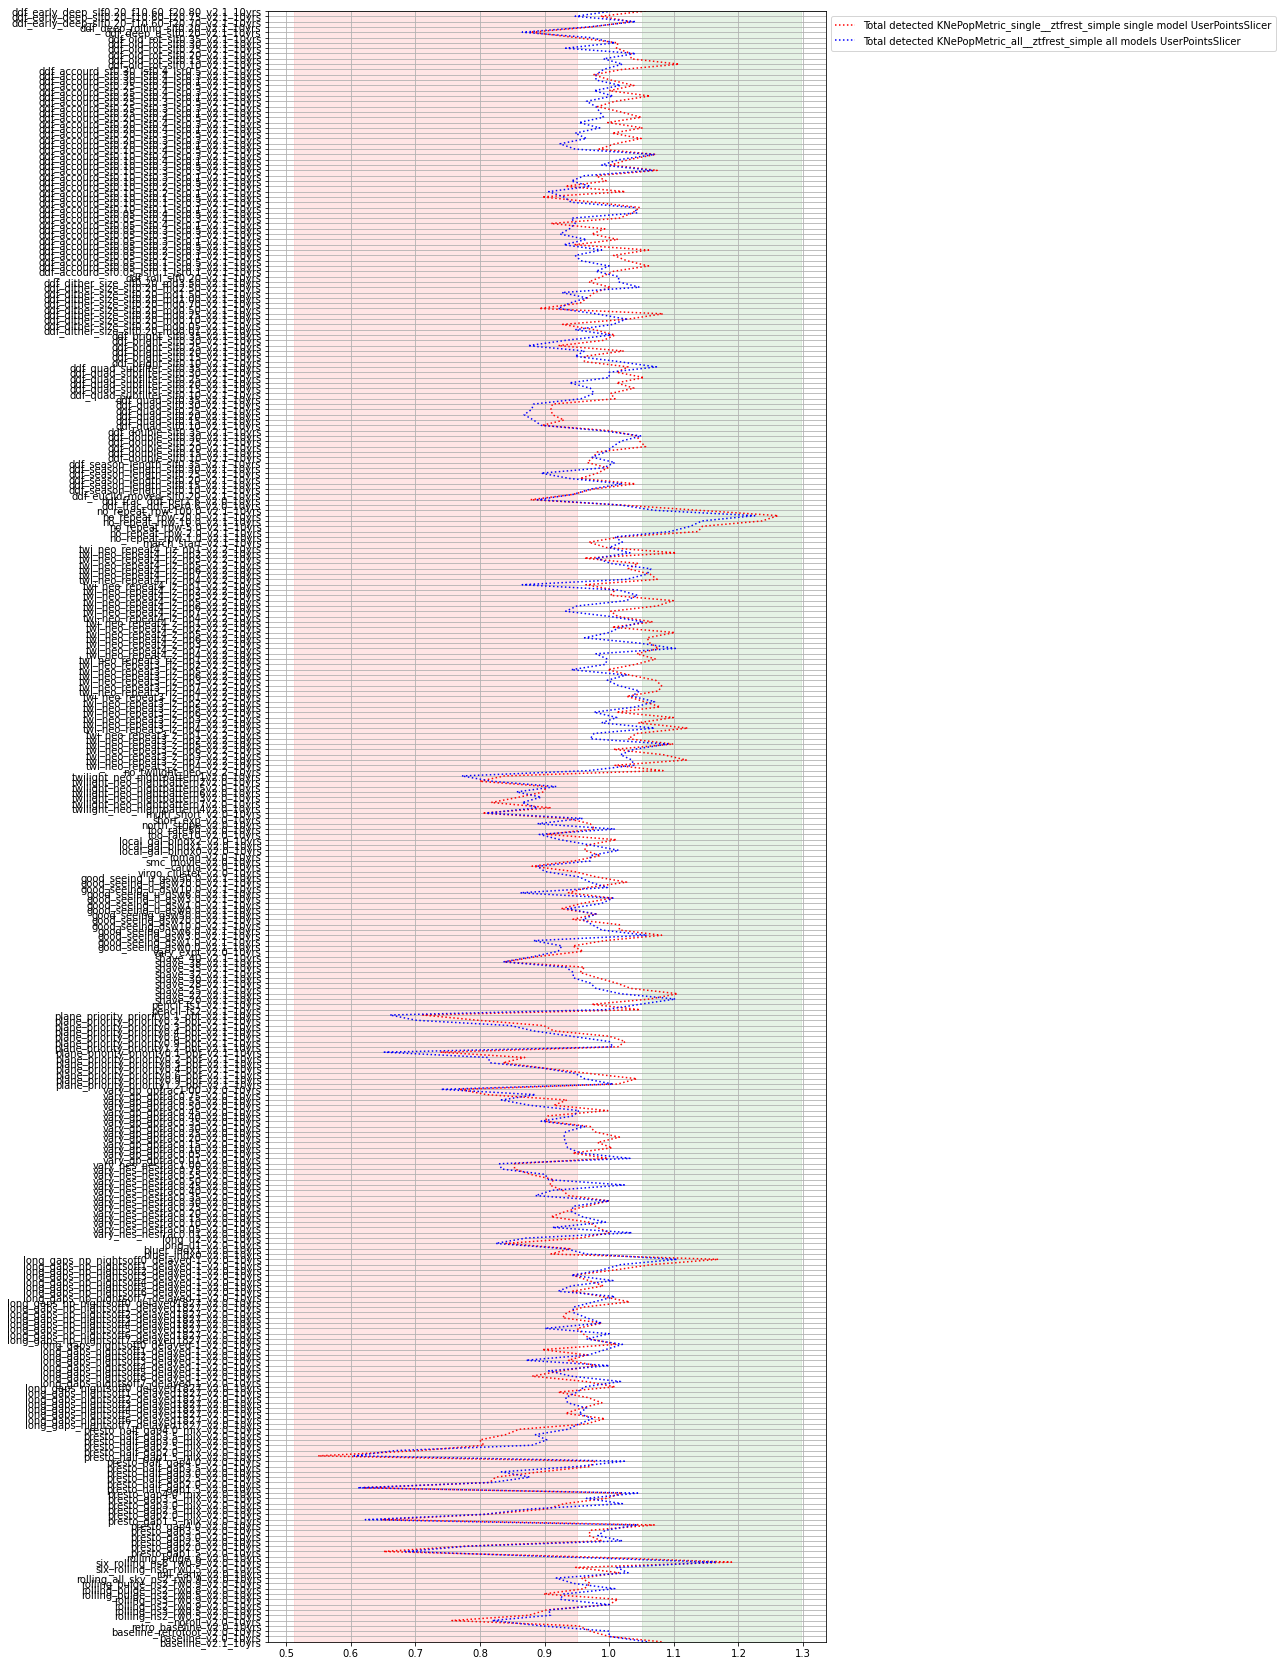

In [75]:
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, color_rise_detect],
                             baseline_run='baseline_v2.0_10yrs',
                              metric_set=msub,
                             horizontal_quantity='value',
                             vertical_quantity='run')
fig.set_figheight(30)